# AUTHOR: Rajesh Bondugula

In [1]:
# Import numpy and matplotlib modiules.
import scipy.special as scp_spl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin_bfgs
%matplotlib inline

from IPython.core.display import HTML
pd.set_option('display.max_rows', 10)

css ="""
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}"""

HTML('<style>{}</style>'.format(css))


## Sigmoid function

- A sigmoid function is a mathematical function having an "S" shape (sigmoid curve).
- It converts any real values number to a fraction in range (0 1) conviniently usable for probabilities.
- It is real-valued and differentiable, having a non-negative or non-positive first derivative
- It has one local minimum, and one local maximum.
- Hence it gives the convex shape and hence finding minimum / maximum is easy with gradient descent or accent.
- Center of Sigmoid occurs at x = 0 and the value is 0.5
- Sigmoid function is given as follows

$$
h\left(x\right)=\frac{1}{1 + e^{-x}}
$$

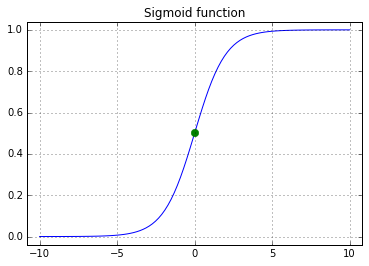

In [2]:
# plot the sigmoid function
x = np.linspace(-10, 10, 100)
y = scp_spl.expit(x) # y = 1 / (1 + np.exp(-x))
plt.plot(x, y)
plt.plot(0, scp_spl.expit(0), 'g.', markersize=15)
plt.margins(0.04)
plt.grid()
plt.title("Sigmoid function");

## Logisic Regression

- Logistic regression is actually a classification problem rather than regression.
- This algorithm takes inputs based on features (real numbers) and ouputs target classes {0, 1, 2, 3, 4 ...}
- In binary classification target = {0, 1}

#### Linear regression

- In Linear regression we find the best fit line on the input training data and calculate the parameters.
- New sample to be predicted is fed into the equation to get the predicted value.
- Below is the question for linear regression. Theta is a parameter vector obtained when algorithm is run on the training set.

$$
h_{\theta}\left(x\right)=\theta^{T}x
$$

#### Binary Logistic regression
- In binary classification there aew two targets {0, 1}.
- One crude way is construct linear regression line and use threshold to separate the classes.
- But this will not give proper results because linear regression predicts real numbers so we have values < 0 and > 1 also.
- We use sigmoid function (also known as logistic function) to convert the values to (0 1) and treat them as probabilities for prediciton.

$$
h_{\theta}\left(x\right)=\frac{1}{1 + e^{-\theta^{T}x}}
$$

- Probability of sample is:
$$
p\left(y=1\mid x; \theta\right) = h_{\theta}\left(x\right) \\ \:\\
p\left(y=0\mid x; \theta\right) = 1 - h_{\theta}\left(x\right)
$$

- This is the prediction condition
$$
Y = 
\begin{cases}
1 \: if \: h_{\theta}\left(x\right) \ge 0.5 \\
0 \: if \: h_{\theta}\left(x\right) < 0.5 \\
\end{cases}
$$

- Alternatively
$$
Y = 
\begin{cases}
1 \: if \: \theta^{T}x \ge 0 \\
0 \: if \: \theta^{T}x < 0 \\
\end{cases}
$$

- Decision boundary
$$
\theta^{T}x = 0
$$

## Cost Function

- Cost is nothing but the error rate between actual and predicted values.
- The cost funciton for linear regression uses sum of squared differences function.
- For logistic regression the same cost function cannot be used because it will not be a convex function.
- It would be a complex function wuth multiple local minimum because of h(x) being sigmoid
- Hence we use the below function to have the convex shape so as to have 1 global minimum.

$$
J\left(\theta\right) =\begin{cases}-log\left(h_{\theta}\left(x^{(i)}\right)\right) if \: y = 1\\ \: \\ -log\left(1-h_{\theta}\left(x^{(i)}\right)\right) if \: y = 0\\ \end{cases}
$$
- The above cost function canbe combined as:
$$
J\left(\theta\right) = \frac{1}{m}\sum_{i=1}^{m} \left[-y^{(i)}log\left(h_{\theta}\left(x^{(i)}\right)\right) -\left(1-y^{(i)}\right)log\left(1-h_{\theta}\left(x^{(i)}\right)\right) \right] \\ x^{\left(i\right)} is \: the \: i^{th} sample \: of \: x
$$



In [3]:
def calculate_cost(theta, X, y):
    """The function returns the cost of the logistic regression

       X     : Input array mxn. m rows are number of samples and n features for each sample.
       y     : Original class of the input
       theta : training parameters
    """
    # Get number of rows
    m = X.shape[0]

    # Convert y and theta into vectors.
    y = np.array(y).reshape(len(y), 1)
    theta = np.array(theta).reshape(len(theta), 1)

    # Append ones as first column to input matrix X.
    # This is because theta is (n + 1) x 1 due to the intercept.
    # The feature value for intercept is 1.
    X = np.column_stack([np.ones(m), X])

    # Calculate the h(x)
    h = scp_spl.expit(np.dot(X, theta))

    # Due the precision constraints, value close to 1 is rounded to 1 and hence log(1-h) is not defined.
    # We adjust the presision so that log is valid.
    # We pick a small value for which precision is retained. exp(-37) is found by trial and error method.
    # We make sure that none of the values neither 0 nor 1.
    precisoin_adjust_value = np.exp(-37)

    h = np.where(h == 1, 1 - precisoin_adjust_value, h)
    h = np.where(h == 0, precisoin_adjust_value, h)

    # Calculate the cost
    J = sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) / m
    return J[0]

## Gradient descent

- Gradient descent is a first-order optimization algorithm.
- To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient of the function at the current point.
- Gradient of a point on the curve gives the tangent to that point.

$$
\theta_j := \theta_j - \alpha \bigtriangledown _\theta J \left( \theta \right) \\ \: \\ J \left( \theta \right) is \: the \: cost \: function. \\ \alpha \: is \: the \: learning \: rate.
$$

#### Procedure
- We start with some initial theta and then calculate the gradient at that point.
- Gradient gives the direction of minimum.
- alpha gives the step length in that direction.
- Update theta by reducing small fraction in that direction.
- The procedure is performed iteraively until the cost is minimum.
- The convergence is said to have occured if there is not change in cost for few consecutive iterations.
- If alpha is very small then it takes long time to converge.
- If alpha is large then it may overshoot and may never converge.
- It is important to choose alpha properly.
- Often chosed by plotting cost over iterations.

## Gradient function

- Given the cost function, we must minimize the cost function and find optimum parameters that give least error on training data
- We calculate the gradient function as first derivative of cost function w.r.t each parameter.
- We use this function in gradient descent to find the parameters that have minimum cost.
- The following function is the gradient function for logistic regression

$$
    \theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i = 1}^{m} \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}
$$

- The above gradient function looks similar to the gradient function of linear regression. However the h(x) is a sigmoid in logistic regression.

In [4]:
def calculate_gradient(theta, X, y):
    """Calculate the gradient of cost function at theta"""

    # Get number of rows
    m = X.shape[0]

    # Convert y and theta into vectors.
    y = np.array(y).reshape(len(y), 1)
    theta = np.array(theta).reshape(len(theta), 1)

    # Append ones as first column to input matrix X.
    # This is because theta is (n + 1) x 1 due to the intercept.
    # The feature value for intercept is 1.
    X = np.column_stack([np.ones(m), X])

    # Calculate the h(x)
    h_y = scp_spl.expit(np.dot(X, theta)) - y
    grad = sum(h_y.repeat(X.shape[1], axis=1) * X) / m

    return grad

## Tuning model parameters. Using BFGS

- There are many ways to minimize the cost function and find the model parameters
- Gradient descent is one of the procedure. However selection of alpha is challenging.
- There are few other algorithms like **Broyden–Fletcher–Goldfarb–Shanno (BFGS) and Low-memory Broyden–Fletcher–Goldfarb–Shanno (L-BFGS)** can also be used.
- There are efficient then gradient descent but complex to understand.
- These are generic algorithms are needs functions for calculating cost and gradient as input.
- we use **fmin_bfgs** from **scipy** to find the minimum of the function.

In [5]:
# perform BFGS and find the parameters that minimize the function.
def get_model_parameters(X, y):
    def f(theta):
        """"""
        return calculate_cost(theta, X, y)

    def fprime(theta):
        return calculate_gradient(theta, X, y)

    # Initial theta assigned to 0
    theta = np.zeros(3)

    return fmin_bfgs(f, theta, fprime, disp=True, maxiter=400)

## Example: Admission classification

Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision.
Your task is to build a classication model that estimates an applicant's probability of admission based the scores from those two exams.

1. Input features: score1, score2 of two exams
2. Target: {0, 1} 0 if not admitted, 1 if admitted

### 1. Data load form file

In [6]:
# Read the data into data frame.
# Dataframe gives better access and view.
data = pd.read_csv('ex2data1.txt', header=None, names=['score1', 'score2', 'admitted'])
X = data.values[:, 0:2]
y = data.values[:, 2]
data

,score1,score2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1
...,...,...,...
95,83.489163,48.380286,1
96,42.261701,87.103851,1
97,99.315009,68.775409,1
98,55.340018,64.931938,1


### 2. Data visualization

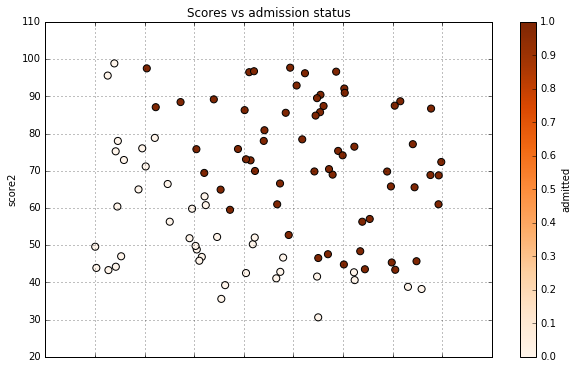

In [7]:
# Plot the data to have a look at the distributon.
data.plot.scatter(x='score1', y='score2', c='admitted', cmap='Oranges', \
                  s=50, grid=True, title="Scores vs admission status", figsize=(10, 6));

### 3. Calculate cost and gradient for default parameters

In [8]:
# Find cost at initial theta.
# Initial theta is zeros.
calculate_cost(np.zeros((3, 1)), X, y)

0.69314718055994584

In [9]:
# Find gradient at initial theta.
# Initial theta is zeros.
calculate_gradient(np.zeros((3, 1)), X, y)

array([ -0.1       , -12.00921659, -11.26284221])

### 4. Perform BFGS on the data to obtain optimum parameters

In [10]:
tuned_theta = get_model_parameters(X, y)
tuned_theta

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 25
         Function evaluations: 33
         Gradient evaluations: 33


array([-25.16132721,   0.20623168,   0.20147154])

### 5. Plot the decision boundary

- Decision boundary is given as below:

$$
\theta^{T}x = 0 \\ \: \\
For \: a\: bivariate \: model \: \theta^{T}x = \theta_0x_0 + \theta_1x_1 + \theta_2x_2 \: \left[Also \: x_0 \: is \: 1\right]
$$
- Rearranging terms from above equation we get:
$$
x_2 = \frac{-\left( \theta_0 + \theta_1x_1\right)}{\theta_2}
$$

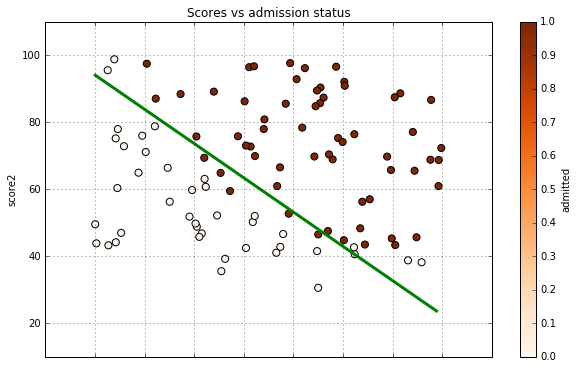

In [11]:
# Plot the decision boundary
data.plot.scatter(x='score1', y='score2', c='admitted', cmap='Oranges', \
                  s=50, grid=True, title="Scores vs admission status", figsize=(10, 6));

# For plotting the boundary line we need two end points.
# Take the min and max of x1 and calcualte x2
x1 = np.array([min(X[:, 0]), max(X[:, 1])])
x2 = -(tuned_theta[0] + tuned_theta[1]*x1) / tuned_theta[2]
plt.plot(x1, x2, color='g', lw=3);

### 6. Perform the prediciton on the data

- As mentione above this is the prediction condition
$$
Y = 
\begin{cases}
1 \: if \: h_{\theta}\left(x\right) \ge 0.5 \\
0 \: if \: h_{\theta}\left(x\right) < 0.5 \\
\end{cases}
$$

- Alternatively
$$
Y = 
\begin{cases}
1 \: if \: \theta^{T}x \ge 0 \\
0 \: if \: \theta^{T}x < 0 \\
\end{cases}
$$

In [12]:
def predict(X, theta):

    # Get number of rows
    m = X.shape[0]

    # Convert theta into vectors.
    theta = np.array(theta).reshape(len(theta), 1)

    # Append ones as first column to input matrix X.
    # This is because theta is (n + 1) x 1 due to the intercept.
    # The feature value for intercept is 1.
    X = np.column_stack([np.ones(m), X])
    
    # Return as class 1 if the value > 0 else return 0
    return np.where(np.dot(X, theta) >= 0, 1, 0).flatten()

In [13]:
predicted_y = predict(X, tuned_theta)
print "Prediction score = ", sum(predicted_y == y)*100/float(len(y)), "%"

Prediction score =  89.0 %
